In [1]:
## loading original data extraction into a data frame for embedding
import pandas as pd
parquet_files=['book2.parquet','home2.parquet','personal_care2.parquet']
dataframes=[pd.read_parquet(files) for files in parquet_files]
df=pd.concat(dataframes,ignore_index=True)

In [2]:
print(df.shape)

(3000000, 3)


In [3]:
## labeling the response column with numerical value
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
df['response']=label_encoder.fit_transform(df['main_category'])


In [5]:
## removing all numbers in the title columns: 
#import re
#import string
#def remove_punctuation(text):
#    return text.translate(str.maketrans('', '', string.punctuation))
#def remove_num(text):
#    text=remove_punctuation(text)
#    return re.sub(r'\d+','',text)

#df['title']= df['title'].apply(remove_num)

In [4]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Function to lemmatize text - remove stop words
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])



In [20]:
## converting using TF-IDF 
#from sklearn.feature_extraction.text import TfidfVectorizer
#tdif=TfidfVectorizer(stop_words='english', preprocessor=lemmatize_text)  ## we can customize stop_words list as well . using default stop_words='english' has very minimal list. Instead we process stop_words and remove it using spacy  
#X=tdif.fit_transform(df['title'])


In [21]:
## saving the vectorizer and resulting tf-dif matrix to a compressed file for future use. 
#from scipy.sparse import save_npz, load_npz
#from sklearn.feature_extraction.text import TfidfVectorizer
#import joblib

#joblib.dump((tdif,X), 'tfidf_vectorizer2.pkl.gz',compress=('gzip',3))



['tfidf_vectorizer2.pkl.gz']

In [22]:
#print(tdif.get_feature_names_out()[101:150])

['AAmerica' 'AAndrea' 'AAngel' 'AAobosi' 'AArbutin' 'AArm' 'AAsXXX'
 'AAtlonia' 'AAtter' 'AB' 'ABA' 'ABACAD' 'ABAKAN' 'ABALDI' 'ABALON'
 'ABAMERICA' 'ABAO' 'ABAPA' 'ABARGK' 'ABASSKY' 'ABATE' 'ABB' 'ABBA' 'ABBB'
 'ABBBED' 'ABBD' 'ABBETEY' 'ABBEY' 'ABBLE' 'ABBLU' 'ABBOT' 'ABBOTT'
 'ABBOUD' 'ABBTO' 'ABBY' 'ABBYE' 'ABBYNEW' 'ABC' 'ABCActivating' 'ABCB'
 'ABCCAMPING' 'ABCCANOPY' 'ABCCBADKAKGINGNHTNLHHTOEOGHTIGTTHHHHHH' 'ABCD'
 'ABCDE' 'ABCDEF' 'ABCDEFG' 'ABCDEFZ' 'ABCDerm']


In [5]:
## Loading the vectorizer file from disk 
import joblib
from scipy.sparse import load_npz

v,X=joblib.load('tfidf_vectorizer2.pkl.gz')

# Testing with new text data using the loaded vectorizer
new_texts = ["New data to transform."]
new_tfidf_matrix = v.transform(new_texts)


In [6]:
print("matrix shape ", X.shape)

matrix shape  (3000000, 624602)


Training logistic regression with 1 variable 'Title' - X is the embedding for title column. 

In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,df['response'],train_size=.8,random_state=123)

In [8]:
## Build logistic model
from sklearn.linear_model import LogisticRegressionCV
#logmod=LogisticRegressionCV(multi_class='multinomial',cv=5, max_iter=10000000).fit(x_train,y_train)

## saving logistic models for future use
#logistic_model_file='LogisticModel_titlefeature_tdif.pkl'
#joblib.dump(logmod,logistic_model_file,compress=('gzip',3))

## call the trained model from disk 

logmod=joblib.load('LogisticModel_titlefeature_tdif.pkl')

train accuracy 0.65009125
[[382334  50280 367379]
 [  5192 788651   5789]
 [360654  50487 389234]]
              precision    recall  f1-score   support

           0       0.51      0.48      0.49    799993
           1       0.89      0.99      0.93    799632
           2       0.51      0.49      0.50    800375

    accuracy                           0.65   2400000
   macro avg       0.64      0.65      0.64   2400000
weighted avg       0.64      0.65      0.64   2400000



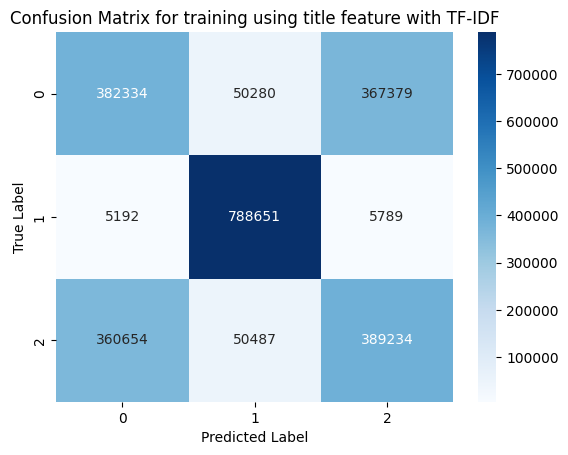

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
ytrain_pred=logmod.predict(x_train)
log_train_matrix=confusion_matrix(y_train,ytrain_pred)
print('train accuracy', accuracy_score(y_train,ytrain_pred))
print(log_train_matrix)

print(classification_report(y_train,ytrain_pred))
from matplotlib import pyplot as plt 
import seaborn as sns 
plt.figure()
sns.heatmap(confusion_matrix(y_train,ytrain_pred), annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel("True Label")
plt.title('Confusion Matrix for training using title feature with TF-IDF')
plt.show()


In [10]:
print(classification_report(y_train,ytrain_pred))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49    799993
           1       0.89      0.99      0.93    799632
           2       0.51      0.49      0.50    800375

    accuracy                           0.65   2400000
   macro avg       0.64      0.65      0.64   2400000
weighted avg       0.64      0.65      0.64   2400000



test accuracy 0.6049566666666667
[[ 81957  12766 105284]
 [  1334 197588   1446]
 [103637  12559  83429]]
              precision    recall  f1-score   support

           0       0.44      0.41      0.42    200007
           1       0.89      0.99      0.93    200368
           2       0.44      0.42      0.43    199625

    accuracy                           0.60    600000
   macro avg       0.59      0.60      0.60    600000
weighted avg       0.59      0.60      0.60    600000



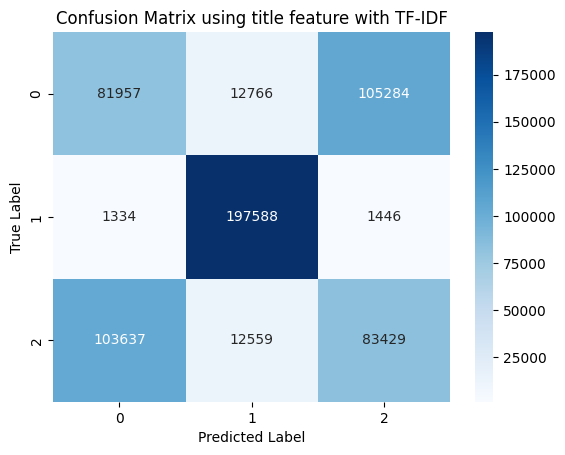

In [11]:
ytest_pred=logmod.predict(x_test)
log_test_matrix=confusion_matrix(y_test,ytest_pred)
print("test accuracy",accuracy_score(y_test,ytest_pred))
print(log_test_matrix)
print(classification_report(y_test,ytest_pred))


# Visualization for confusion matrix
from matplotlib import pyplot as plt 
import seaborn as sns 
plt.figure()
sns.heatmap(confusion_matrix(y_test,ytest_pred), annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel("True Label")
plt.title('Confusion Matrix using title feature with TF-IDF')
plt.show()

In [12]:
label_encoder.classes_

array(['book2', 'home', 'personal_care'], dtype=object)

The prediction for home product based on title gain a significant high accuracy while book and personalcare show intermixed results.